In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import shap
from scipy.stats import pearsonr, spearmanr, ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

In [6]:
df = pd.read_csv('insurance.csv')
df.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Age                      986 non-null    int64
 1   Diabetes                 986 non-null    int64
 2   BloodPressureProblems    986 non-null    int64
 3   AnyTransplants           986 non-null    int64
 4   AnyChronicDiseases       986 non-null    int64
 5   Height                   986 non-null    int64
 6   Weight                   986 non-null    int64
 7   KnownAllergies           986 non-null    int64
 8   HistoryOfCancerInFamily  986 non-null    int64
 9   NumberOfMajorSurgeries   986 non-null    int64
 10  PremiumPrice             986 non-null    int64
dtypes: int64(11)
memory usage: 84.9 KB


In [8]:
df.shape

(986, 11)

- We have 986 records and 11 features in our data including the target variable.

In [9]:
df.isna().sum()

Age                        0
Diabetes                   0
BloodPressureProblems      0
AnyTransplants             0
AnyChronicDiseases         0
Height                     0
Weight                     0
KnownAllergies             0
HistoryOfCancerInFamily    0
NumberOfMajorSurgeries     0
PremiumPrice               0
dtype: int64

- No null values are present in data.

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,986.0,41.745436,13.963371,18.0,30.0,42.0,53.0,66.0
Diabetes,986.0,0.419878,0.493789,0.0,0.0,0.0,1.0,1.0
BloodPressureProblems,986.0,0.468560,0.499264,0.0,0.0,0.0,1.0,1.0
AnyTransplants,986.0,0.055781,0.229615,0.0,0.0,0.0,0.0,1.0
AnyChronicDiseases,986.0,0.180527,0.384821,0.0,0.0,0.0,0.0,1.0
Height,986.0,168.182556,10.098155,145.0,161.0,168.0,176.0,188.0
Weight,986.0,76.950304,14.265096,51.0,67.0,75.0,87.0,132.0
KnownAllergies,986.0,0.215010,0.411038,0.0,0.0,0.0,0.0,1.0
HistoryOfCancerInFamily,986.0,0.117647,0.322353,0.0,0.0,0.0,0.0,1.0
NumberOfMajorSurgeries,986.0,0.667343,0.749205,0.0,0.0,1.0,1.0,3.0


- The minimum age in our data is 18 and maximum age is 66. The mean age is 41.74 and the median is 42 which are almost similar, Therefore no ourliers present for Age.
- Mean and Median for Weight and Height is also similar, Therefore no outliers present in the data.

In [11]:
df.nunique()

Age                        49
Diabetes                    2
BloodPressureProblems       2
AnyTransplants              2
AnyChronicDiseases          2
Height                     44
Weight                     74
KnownAllergies              2
HistoryOfCancerInFamily     2
NumberOfMajorSurgeries      4
PremiumPrice               24
dtype: int64

In [12]:
cat_cols = ['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily']
for col in cat_cols:
    des = f'Distribution of data in categorical column: {col}'
    print("*"*len(des)+"\n"+des+"\n"+"*"*len(des))
    print(df[col].value_counts(),"\n\n")


****************************************************
Distribution of data in categorical column: Diabetes
****************************************************
Diabetes
0    572
1    414
Name: count, dtype: int64 


*****************************************************************
Distribution of data in categorical column: BloodPressureProblems
*****************************************************************
BloodPressureProblems
0    524
1    462
Name: count, dtype: int64 


**********************************************************
Distribution of data in categorical column: AnyTransplants
**********************************************************
AnyTransplants
0    931
1     55
Name: count, dtype: int64 


**************************************************************
Distribution of data in categorical column: AnyChronicDiseases
**************************************************************
AnyChronicDiseases
0    808
1    178
Name: count, dtype: int64 


************************

In [13]:
summary_table = pd.DataFrame()
summary_percentage = pd.DataFrame()
for col in cat_cols:
    counts = df[col].value_counts()
    summary_table[col] = counts.astype(str) + " ("+round((counts/len(df))*100,2).astype(str)+"%"+")"
summary_table

,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,KnownAllergies,HistoryOfCancerInFamily
Diabetes,,,,,,
0,572 (58.01%),524 (53.14%),931 (94.42%),808 (81.95%),774 (78.5%),870 (88.24%)
1,414 (41.99%),462 (46.86%),55 (5.58%),178 (18.05%),212 (21.5%),116 (11.76%)


In [14]:
df.columns

Index(['Age', 'Diabetes', 'BloodPressureProblems', 'AnyTransplants',
       'AnyChronicDiseases', 'Height', 'Weight', 'KnownAllergies',
       'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries', 'PremiumPrice'],
      dtype='object')

### Checking Distribution of Data

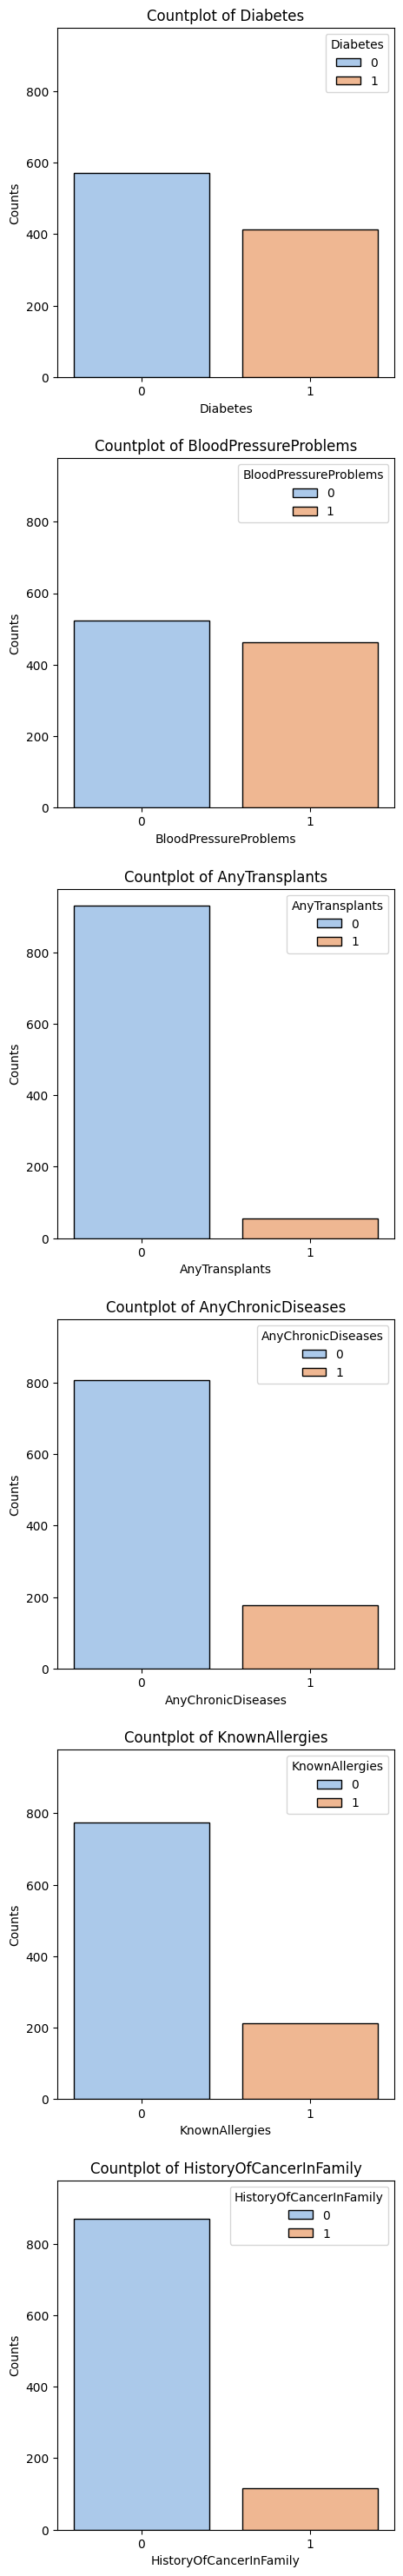

In [15]:
total_cols = len(cat_cols)
# Create subplots
fig, axes = plt.subplots(total_cols, 1, figsize=(5, 5 * total_cols), sharey=True)
for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=df, ax=axes[i], hue=col, palette='pastel', edgecolor='black')
    axes[i].set_title(f'Countplot of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Counts')
    plt.tight_layout(pad=2)

In [16]:
num_cols = ['Age', 'Height', 'Weight', 'PremiumPrice']

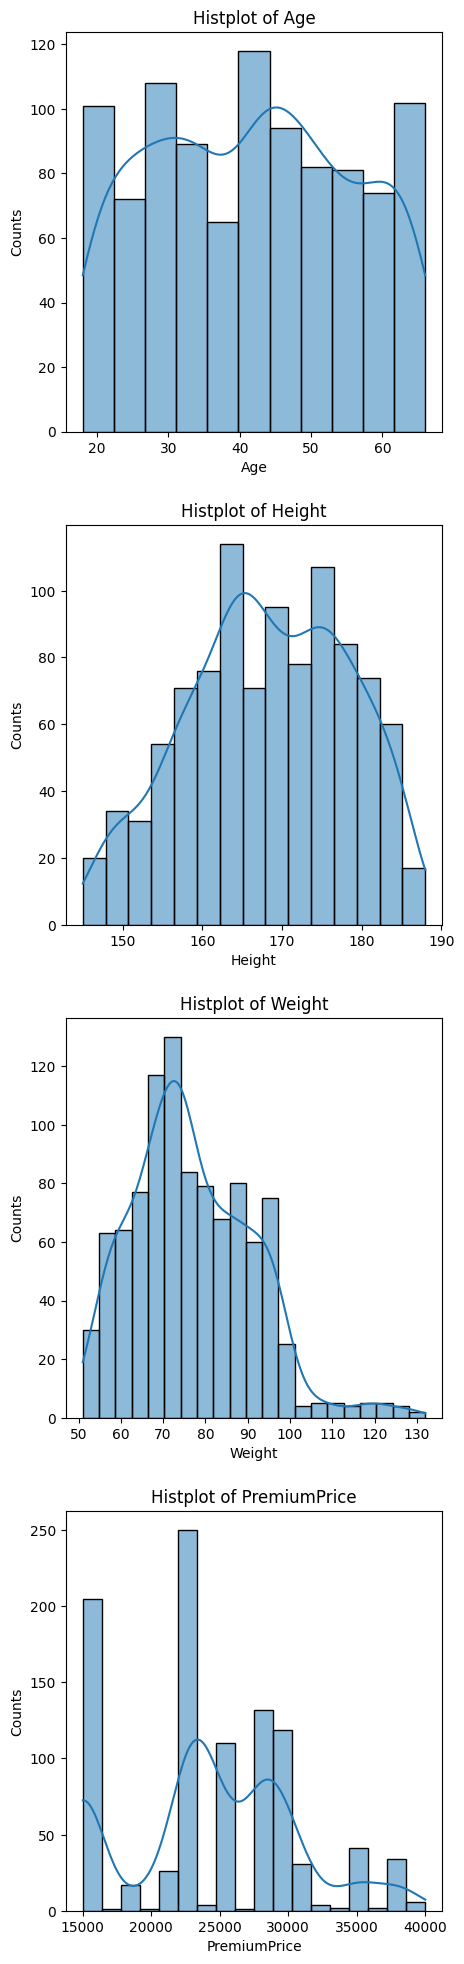

In [17]:
total_cols = len(num_cols)
# Create subplots
fig, axes = plt.subplots(total_cols, 1, figsize=(5, 5 * total_cols))
for i, col in enumerate(num_cols):
    sns.histplot(x=col, data=df, ax=axes[i], edgecolor='black', kde=True)
    axes[i].set_title(f'Histplot of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Counts')
    plt.tight_layout(pad=2)

<Axes: ylabel='PremiumPrice'>

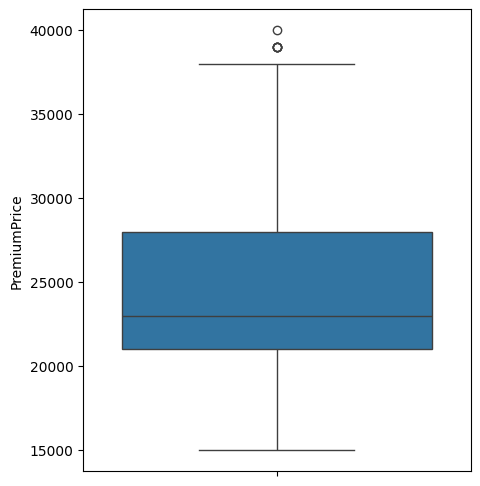

In [18]:
plt.figure(figsize=(5,6))
sns.boxplot(df['PremiumPrice'])

<Axes: xlabel='Age', ylabel='PremiumPrice'>

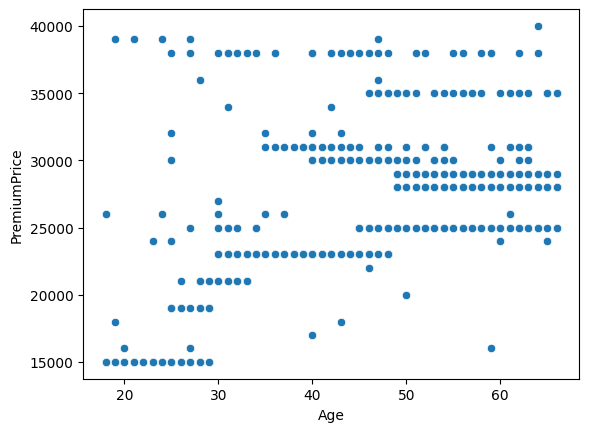

In [19]:
sns.scatterplot(data=df, x='Age', y='PremiumPrice')

### Separating Healthy and Unhealthy people for further analysis

In [20]:
df_healthy = df[(df[['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries']]==0).all(axis=1)]
df_unhealthy = df[~(df[['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries']]==0).all(axis=1)]

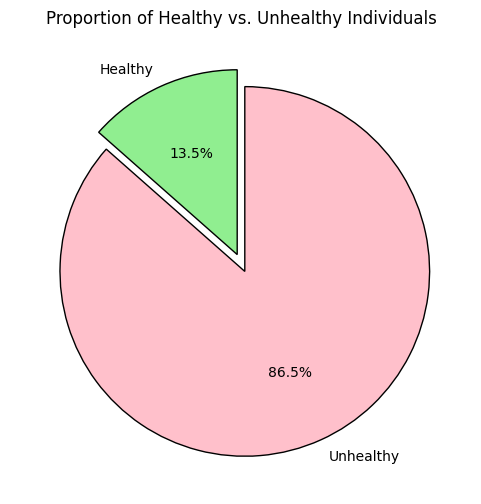

In [21]:
# Count the number of healthy and unhealthy rows
healthy_count = df_healthy.shape[0]
unhealthy_count = df_unhealthy.shape[0]

# Labels and data for the pie chart
labels = ['Healthy', 'Unhealthy']
sizes = [healthy_count, unhealthy_count]

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', explode = [0.05,0.05], colors=['lightgreen', 'pink'], startangle=90, wedgeprops={'edgecolor': 'black'})  # Adds black edges for clarity

plt.title('Proportion of Healthy vs. Unhealthy Individuals')
plt.show()

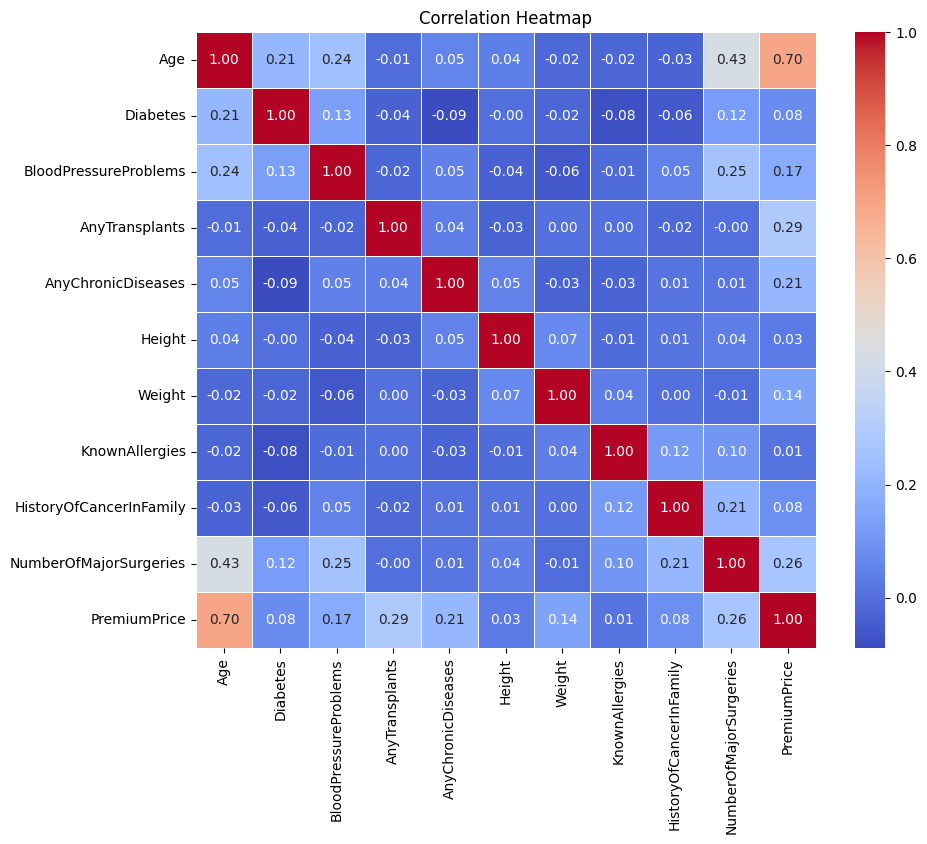

In [22]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

### Hypothesis Testing

#### Correlation Matrix

In [23]:
corr = df[['Age', 'Weight', 'Height', 'PremiumPrice']].corr()
print(corr)

                   Age    Weight    Height  PremiumPrice
Age           1.000000 -0.018590  0.039879      0.697540
Weight       -0.018590  1.000000  0.066946      0.141507
Height        0.039879  0.066946  1.000000      0.026910
PremiumPrice  0.697540  0.141507  0.026910      1.000000


#### Correlation test for Numerical Features

***************************************
Hypothesis Test : Age and Premium Costs
***************************************
Pearson correlation: 0.6975399655058028, p-value: 1.322507157832202e-144


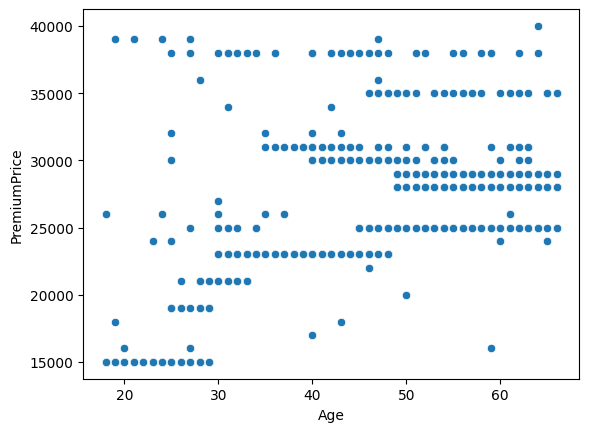

Result: Significant correlation between Age and PremiumPrice.


******************************************
Hypothesis Test : Weight and Premium Costs
******************************************
Pearson correlation: 0.14150740525639743, p-value: 8.186473650456375e-06


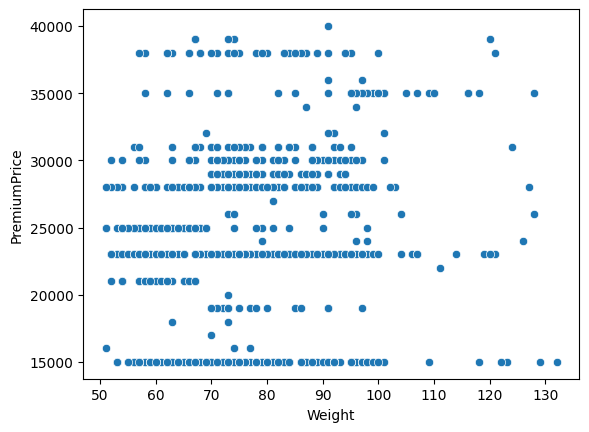

Result: Significant correlation between Weight and PremiumPrice.


******************************************
Hypothesis Test : Height and Premium Costs
******************************************
Pearson correlation: 0.026909513982139983, p-value: 0.3986376207316487


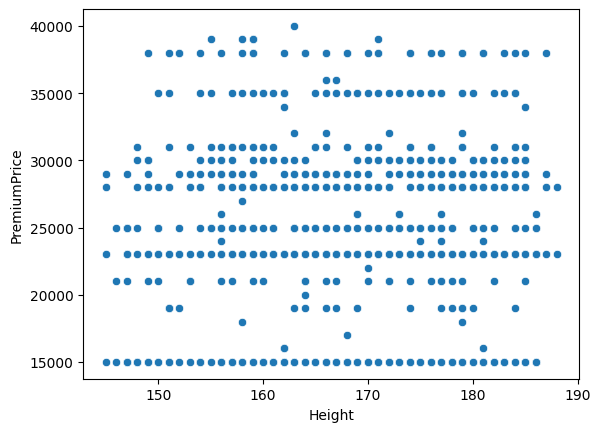

Result: No significant correlation between Height and PremiumPrice.




In [24]:
cols = ['Age', 'Weight', 'Height']

for col in cols:
    l=len(f"Hypothesis Test : {col} and Premium Costs")

    # Perform Pearson Correlation Test
    corr, p_value = pearsonr(df[col], df['PremiumPrice'])
    print("*"*l)
    print(f"Hypothesis Test : {col} and Premium Costs")
    print("*"*l)
    print(f"Pearson correlation: {corr}, p-value: {p_value}")
    
    sns.scatterplot(x=df[col], y=df['PremiumPrice'])
    plt.show()

    if p_value < 0.05:
        print(f"Result: Significant correlation between {col} and PremiumPrice.\n\n")
    else:
        print(f"Result: No significant correlation between {col} and PremiumPrice.\n\n")


- Height has No Significant correlation with Premium Price.

#### Correlation test for ordinal feature

In [25]:
corr, p_value = spearmanr(df['NumberOfMajorSurgeries'], df['PremiumPrice'])
print(f"Spearman correlation: {corr}, p-value: {p_value}")

if p_value < 0.05:
    print("Result: Reject the null hypothesis.\nNumberOfMajorSurgeries have significant impact on Premium Prices.")
else:
    print("Result: Failed to reject the null hypothesis.\nNumberOfMajorSurgeries have no impact on Premium Prices")

Spearman correlation: 0.28948194124643145, p-value: 1.7309753268947138e-20
Result: Reject the null hypothesis.
NumberOfMajorSurgeries have significant impact on Premium Prices.


#### T-Test for Categorical Features

********************************************
Hypothesis Test : Diabetes and Premium Costs
********************************************
T-statistic: 2.40, P-value: 0.02


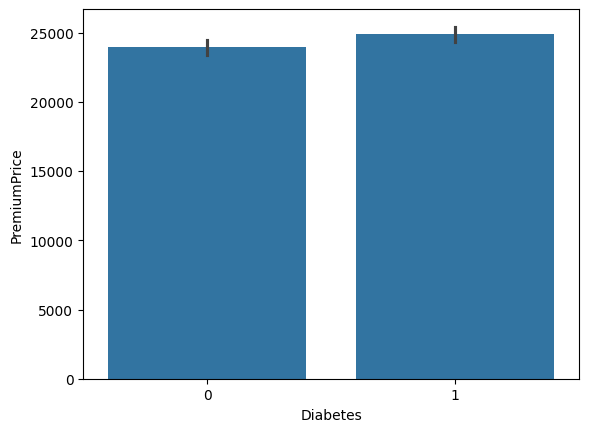

Result: Reject the null hypothesis.
Diabetes have significant impact on Premium Prices


*********************************************************
Hypothesis Test : BloodPressureProblems and Premium Costs
*********************************************************
T-statistic: 5.32, P-value: 0.00


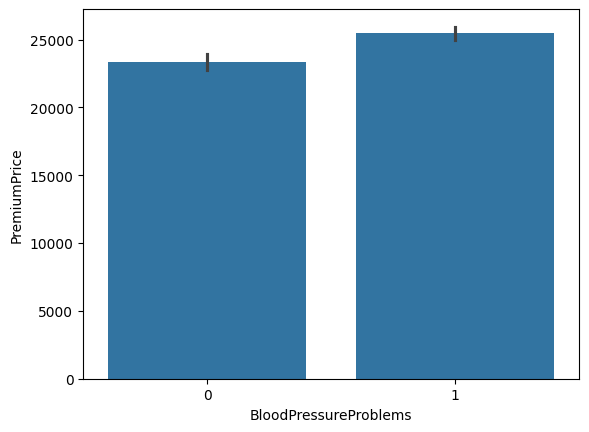

Result: Reject the null hypothesis.
BloodPressureProblems have significant impact on Premium Prices


**************************************************
Hypothesis Test : AnyTransplants and Premium Costs
**************************************************
T-statistic: 9.47, P-value: 0.00


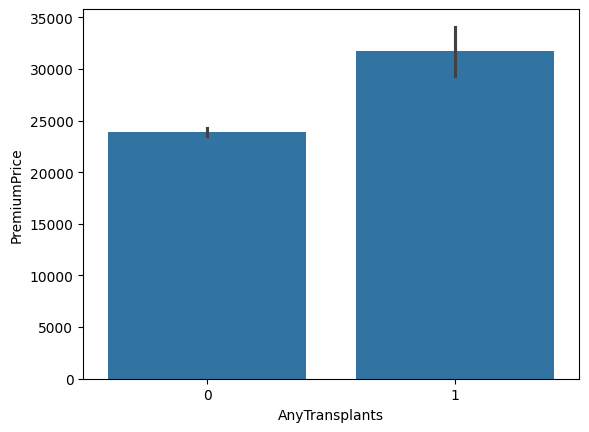

Result: Reject the null hypothesis.
AnyTransplants have significant impact on Premium Prices


******************************************************
Hypothesis Test : AnyChronicDiseases and Premium Costs
******************************************************
T-statistic: 6.69, P-value: 0.00


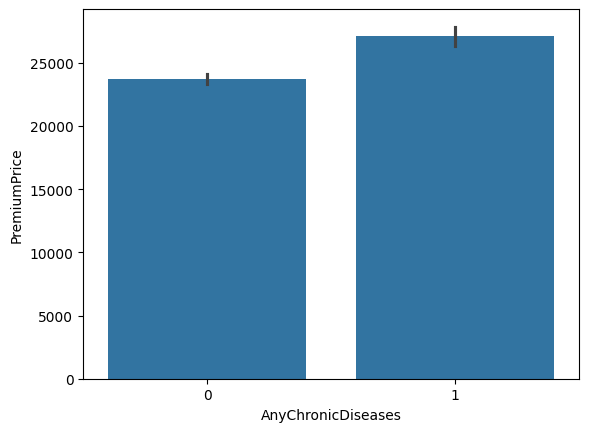

Result: Reject the null hypothesis.
AnyChronicDiseases have significant impact on Premium Prices


**************************************************
Hypothesis Test : KnownAllergies and Premium Costs
**************************************************
T-statistic: 0.38, P-value: 0.70


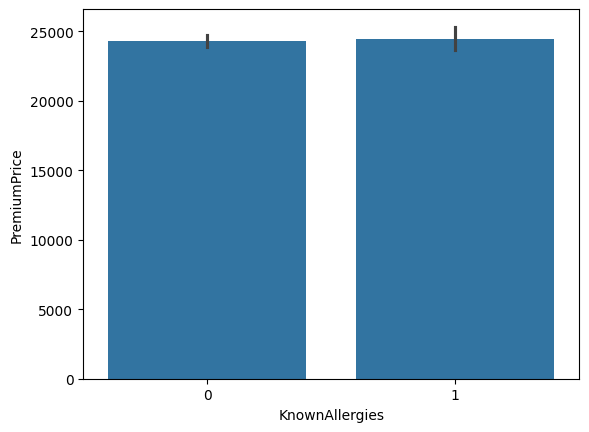

Result: Failed to reject the null hypothesis.
KnownAllergies have no impact on Premium Prices


***********************************************************
Hypothesis Test : HistoryOfCancerInFamily and Premium Costs
***********************************************************
T-statistic: 2.62, P-value: 0.01


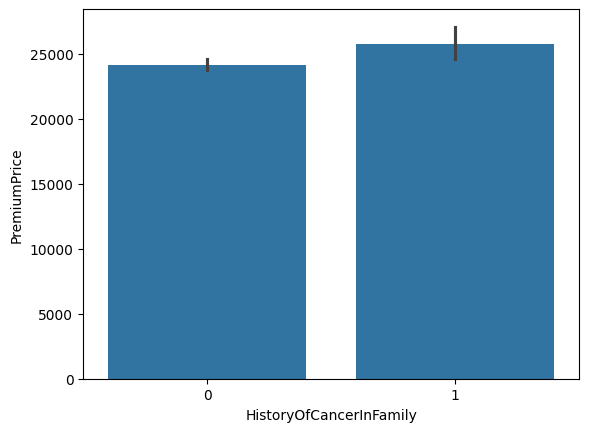

Result: Reject the null hypothesis.
HistoryOfCancerInFamily have significant impact on Premium Prices




In [26]:
for col in cat_cols:
    # Separate premium costs based on the presence of diseases
    with_disease = df[df[col] == 1]['PremiumPrice']
    without_disease = df[df[col] == 0]['PremiumPrice']

    l=len(f"Hypothesis Test : {col} and Premium Costs")
    # Perform an independent t-test
    t_stat, p_value = ttest_ind(with_disease, without_disease)

    print("*"*l)
    print(f"Hypothesis Test : {col} and Premium Costs")
    print("*"*l)
    print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.2f}")
    sns.barplot(x=df[col], y=df['PremiumPrice'], estimator='mean')
    plt.show()

    if p_value < 0.05:
        print(f"Result: Reject the null hypothesis.\n{col} have significant impact on Premium Prices\n\n")
    else:
        print(f"Result: Failed to reject the null hypothesis.\n{col} have no impact on Premium Prices\n\n")

- Known Allergies have no impact on the Premium Prices.

### Feature Engineering & Data Preprocessing

***Feature Scaling***

In [27]:
scaler = StandardScaler()
df[['Age', 'Height', 'Weight']] = scaler.fit_transform(df[['Age', 'Height', 'Weight']])

In [28]:
# Saving Scaler file as pickle file
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

### Splitting the Data

In [29]:
X = df.drop('PremiumPrice', axis=1)
y = df['PremiumPrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
X_train.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries
762,-1.629763,0,0,0,0,-2.197809,-1.539523,0,0,0
334,-0.769935,0,1,0,0,-0.612557,0.704853,0,0,0
890,1.164677,1,0,0,0,-2.098731,-0.136788,0,0,0
529,-0.769935,0,1,0,0,0.279147,0.564580,0,0,0
468,-1.128196,1,1,0,0,-0.117166,-0.487472,0,1,1


### Model Building

In [31]:
# Function to Display Model performance Metrics
def model_metrics(modelType, metricsFor, actualVal, predVal):
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    
    MAE = round(mean_absolute_error(actualVal, predVal),2)
    RMSE = round(np.sqrt(mean_squared_error(actualVal, predVal)),2)
    R2 = round(r2_score(actualVal, predVal),2)

    print(f"Prediction Result of {modelType} on {metricsFor}")
    print(f"{modelType} MAE:", MAE)
    print(f"{modelType} RMSE:", RMSE)
    print(f"{modelType} R^2:", R2,'\n')

In [32]:
def plot_residuals(model):
    pred = model.predict(X_test)
    # Calculate Residuals
    residuals = y_test - pred
    # Calculate R² Score
    r2 = r2_score(y_test, pred)

    # Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))

    # Residual Plot
    axes[0].scatter(pred, residuals, alpha=0.6)
    axes[0].axhline(0, color='red', linestyle='--', lw=2)
    axes[0].set_xlabel('Predicted Premium Price')
    axes[0].set_ylabel('Residuals (Actual - Predicted)')
    axes[0].set_title('Residual Plot')

    # Actual vs. Predicted Scatter Plot
    sns.scatterplot(x=y_test, y=pred, alpha=0.6, ax=axes[1])
    axes[1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle="--", lw=2)
    axes[1].set_xlabel("Actual Premium Price")
    axes[1].set_ylabel("Predicted Premium Price")
    axes[1].set_title(f"Actual vs. Predicted (R² = {r2:.2f})")

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

### ***Linear Regression***

Prediction Result of Linear Regression on Train Data
Linear Regression MAE: 2692.47
Linear Regression RMSE: 3793.46
Linear Regression R^2: 0.62 

Prediction Result of Linear Regression on Test Data
Linear Regression MAE: 2586.23
Linear Regression RMSE: 3495.95
Linear Regression R^2: 0.71 



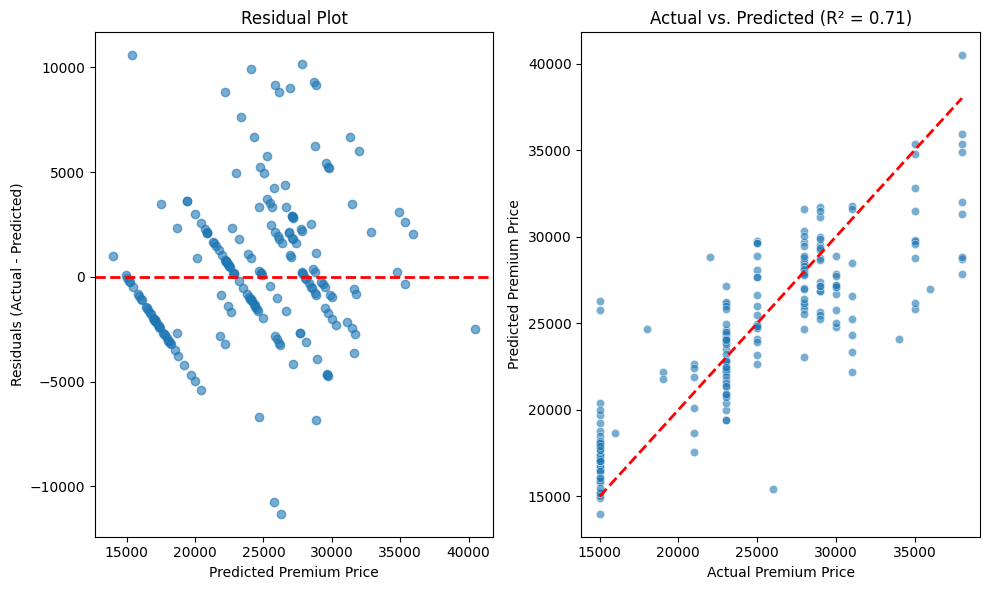

In [33]:
# Initialize the Model
lr = LinearRegression()
# Train the model on the training data
lr.fit(X_train, y_train)

# Predict Train Value and Metrics
y_train_pred_lr = lr.predict(X_train)
model_metrics('Linear Regression', 'Train Data', y_train, y_train_pred_lr)

# Predict Test Value and Metrics
y_test_pred_lr = lr.predict(X_test)
model_metrics('Linear Regression', 'Test Data', y_test, y_test_pred_lr)

# Plotting Residuals
plot_residuals(lr)

### ***Random Forest Regressor***

Prediction Result of Random Forest Regressor on Train Data
Random Forest Regressor MAE: 452.5
Random Forest Regressor RMSE: 1099.19
Random Forest Regressor R^2: 0.97 

Prediction Result of Random Forest Regressor on Test Data
Random Forest Regressor MAE: 1036.97
Random Forest Regressor RMSE: 2309.59
Random Forest Regressor R^2: 0.87 



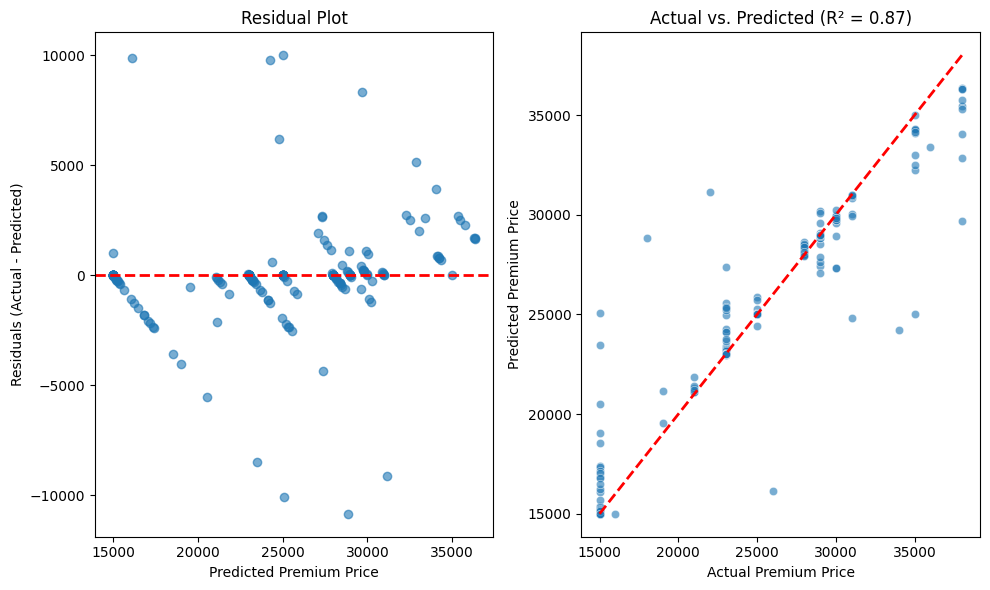

In [34]:
# Initialize the Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
# Train the model on the training data
rf.fit(X_train, y_train)

# Predict Train Value and Metrics
y_train_pred_rf = rf.predict(X_train)
model_metrics('Random Forest Regressor', 'Train Data', y_train, y_train_pred_rf)

# Predict Test Value and Metrics
y_test_pred_rf = rf.predict(X_test)
model_metrics('Random Forest Regressor', 'Test Data', y_test, y_test_pred_rf)

# Plotting Residuals
plot_residuals(rf)

### ***GBDT Regressor***

Prediction Result of Gradient Boosting Regressor on Train Data
Gradient Boosting Regressor MAE: 1179.02
Gradient Boosting Regressor RMSE: 2138.06
Gradient Boosting Regressor R^2: 0.88 

Prediction Result of Gradient Boosting Regressor on Test Data
Gradient Boosting Regressor MAE: 1503.64
Gradient Boosting Regressor RMSE: 2480.21
Gradient Boosting Regressor R^2: 0.86 



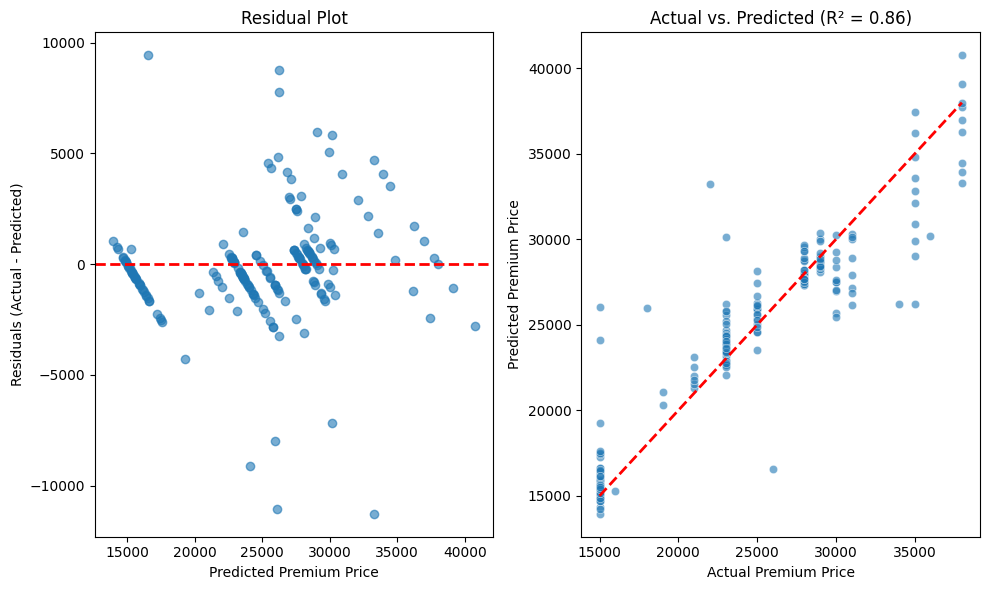

In [35]:
# Initialize the Model
gbdt = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
# Train the model on the training data
gbdt.fit(X_train, y_train)

# Predict Train Value and Metrics
y_train_pred_gbdt = gbdt.predict(X_train)
model_metrics('Gradient Boosting Regressor', 'Train Data', y_train, y_train_pred_gbdt)

# Predict Test Value and Metrics
y_test_pred_gbdt = gbdt.predict(X_test)
model_metrics('Gradient Boosting Regressor', 'Test Data', y_test, y_test_pred_gbdt)

# Plotting Residuals
plot_residuals(gbdt)

### ***XGB Regressor***

In [36]:
# !pip install xgboost

Prediction Result of XGB Regressor on Train Data
XGB Regressor MAE: 385.0
XGB Regressor RMSE: 600.56
XGB Regressor R^2: 0.99 

Prediction Result of XGB Regressor on Test Data
XGB Regressor MAE: 1513.22
XGB Regressor RMSE: 2622.34
XGB Regressor R^2: 0.84 



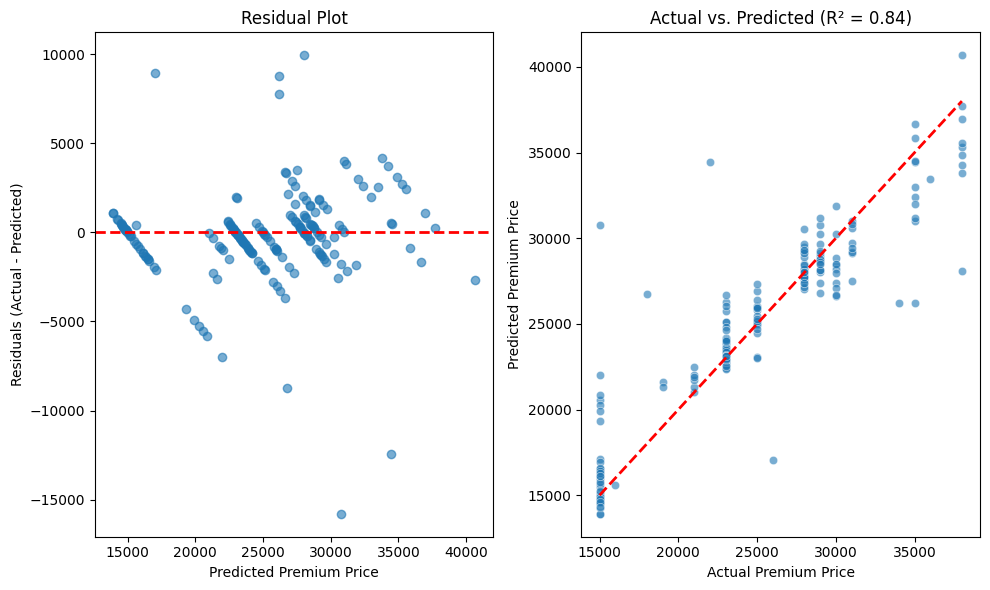

In [37]:
# Initialize the Model
xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42)
# Train the model on the training data
xgb.fit(X_train, y_train)

# Predict Train Value and Metrics
y_train_pred_xgb = xgb.predict(X_train)
model_metrics('XGB Regressor', 'Train Data', y_train, y_train_pred_xgb)

# Predict Test Value and Metrics
y_test_pred_xgb = xgb.predict(X_test)
model_metrics('XGB Regressor', 'Test Data', y_test, y_test_pred_xgb)

# Plotting Residuals
plot_residuals(xgb)

### Cross-Validation

In [38]:
models = {'Linear Regression':lr, 'Random Forest Regressor':rf, 'Gradient Boosting Regressor':gbdt, 'XGB Regressor':xgb}

In [39]:
for model_name,model in models.items():
    head = f'{model_name} CV Metrics'
    print("*"*len(head)+"\n"+head+"\n"+"*"*len(head))
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores)
    print("RMSE:", round(cv_rmse.mean(),2))

    cv_r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    print("R2:", round(cv_r2_scores.mean(),2),'\n')

****************************
Linear Regression CV Metrics
****************************
RMSE: 3871.76
R2: 0.6 

**********************************
Random Forest Regressor CV Metrics
**********************************
RMSE: 3064.08
R2: 0.75 

**************************************
Gradient Boosting Regressor CV Metrics
**************************************
RMSE: 3090.0
R2: 0.74 

************************
XGB Regressor CV Metrics
************************
RMSE: 3074.35
R2: 0.75 



### Hyperparameter Tuning

#### **Ridge**

Best Parameters (Alpha): {'alpha': 1}

Prediction Result of Ridge on Train Data
Ridge MAE: 2694.0
Ridge RMSE: 3793.7
Ridge R^2: 0.62 


Prediction Result of Ridge on Test Data
Ridge MAE: 2592.39
Ridge RMSE: 3503.41
Ridge R^2: 0.71 



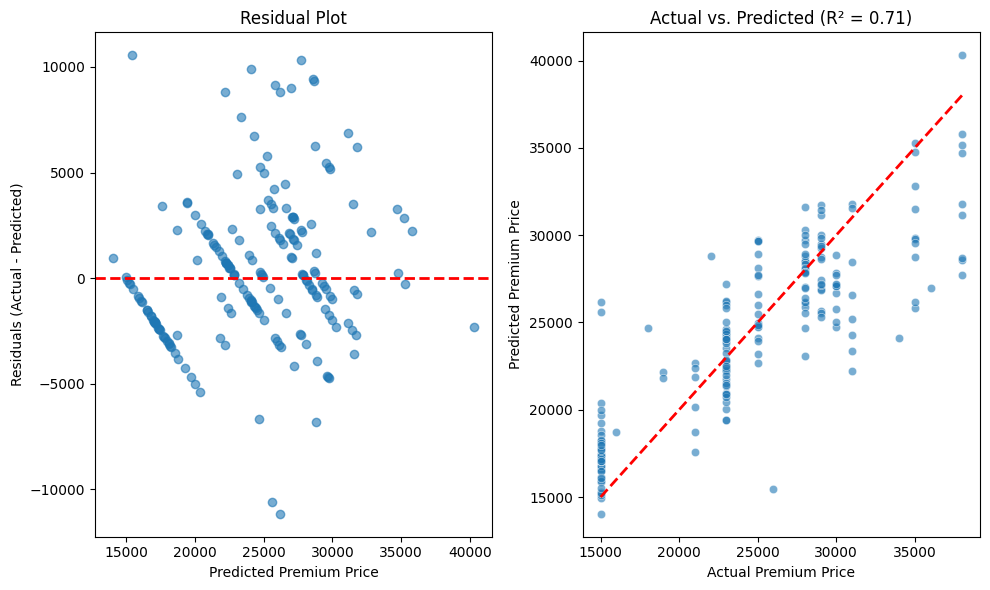

In [40]:
# Hyperparameter Tuning for Linear Regression
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Ridge Regression Tuning
grid_search_ridge = GridSearchCV(Ridge(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_ridge.fit(X_train, y_train)

print("Best Parameters (Alpha):", grid_search_ridge.best_params_)
print()
best_ridge = grid_search_ridge.best_estimator_

# Fitting the best model
best_ridge.fit(X_train, y_train)

y_train_pred_ridge = best_ridge.predict(X_train)
model_metrics('Ridge', 'Train Data', y_train, y_train_pred_ridge)
print()
y_test_pred_ridge = best_ridge.predict(X_test)
model_metrics('Ridge', 'Test Data', y_test, y_test_pred_ridge)

# Plotting Residuals
plot_residuals(best_ridge)

#### **Lasso**

Best Parameters (Alpha): {'alpha': 10}

Prediction Result of Lasso on Train Data
Lasso MAE: 2693.33
Lasso RMSE: 3794.26
Lasso R^2: 0.62 


Prediction Result of Lasso on Test Data
Lasso MAE: 2596.73
Lasso RMSE: 3510.18
Lasso R^2: 0.71 



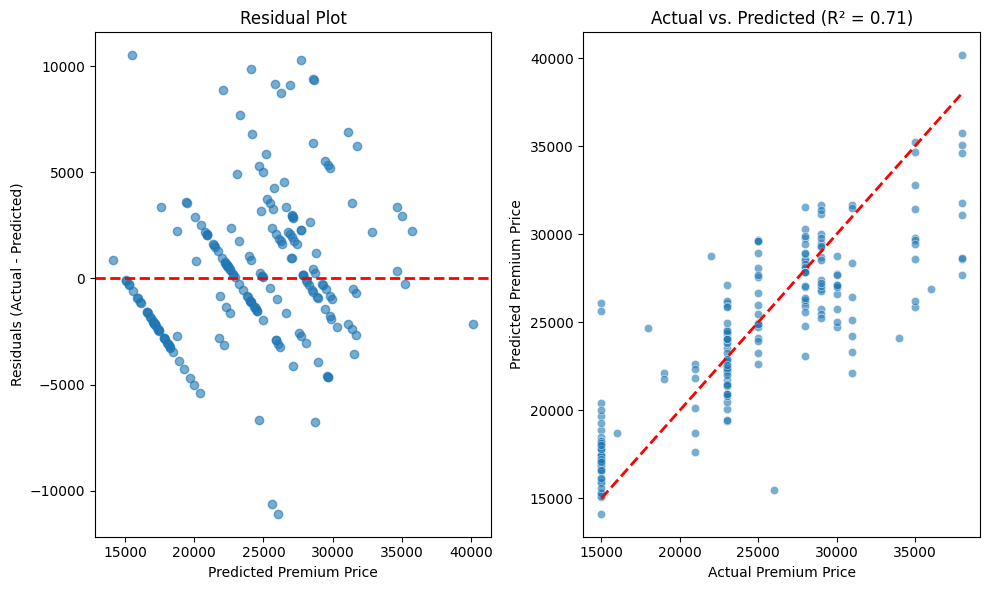

In [41]:
# Lasso Regression Tuning
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

grid_search_lasso = GridSearchCV(Lasso(max_iter=10000, random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X_train, y_train)

print("Best Parameters (Alpha):", grid_search_lasso.best_params_)
print()
best_lasso = grid_search_lasso.best_estimator_

# Fitting the best model
best_lasso.fit(X_train, y_train)

y_train_pred_lasso = best_lasso.predict(X_train)
model_metrics('Lasso', 'Train Data', y_train, y_train_pred_lasso)
print()
y_test_pred_lasso = best_lasso.predict(X_test)
model_metrics('Lasso', 'Test Data', y_test, y_test_pred_lasso)

# Plotting Residuals
plot_residuals(best_lasso)

#### **Elastic Net**

Best Parameters: {'alpha': 0.01, 'l1_ratio': 0.9}

Prediction Result of Elastic Net on Train Data
Elastic Net MAE: 2693.67
Elastic Net RMSE: 3793.61
Elastic Net R^2: 0.62 


Prediction Result of Elastic Net on Test Data
Elastic Net MAE: 2591.11
Elastic Net RMSE: 3501.82
Elastic Net R^2: 0.71 



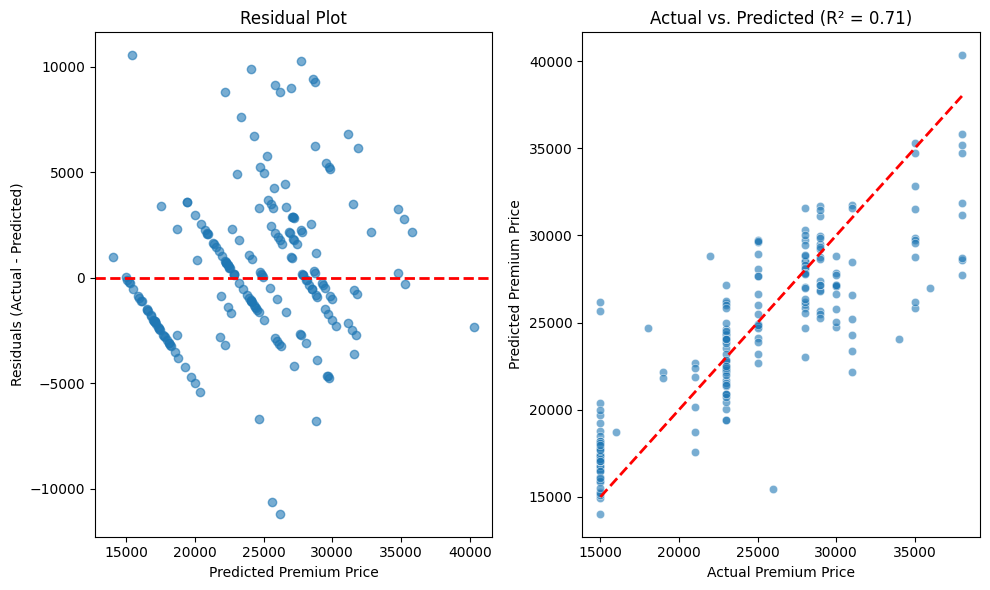

In [42]:
# Lasso Regression Tuning
param_grid = {
    'alpha': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.5, 0.9]  # Mix of L1 and L2 regularization
}

grid_search_elastic = GridSearchCV(ElasticNet(max_iter=10000, random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_elastic.fit(X_train, y_train)

print("Best Parameters:", grid_search_elastic.best_params_)
print()
best_elastic = grid_search_elastic.best_estimator_

# Fitting the best model
best_elastic.fit(X_train, y_train)

y_train_pred_elastic = best_elastic.predict(X_train)
model_metrics('Elastic Net', 'Train Data', y_train, y_train_pred_elastic)
print()
y_test_pred_elastic = best_elastic.predict(X_test)
model_metrics('Elastic Net', 'Test Data', y_test, y_test_pred_elastic)

# Plotting Residuals
plot_residuals(best_elastic)

#### **Random Forest Regressor**

Best Parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}

Prediction Result of Random Forest Regressor on Train Data
Random Forest Regressor MAE: 813.87
Random Forest Regressor RMSE: 2077.88
Random Forest Regressor R^2: 0.89 


Prediction Result of Random Forest Regressor on Test Data
Random Forest Regressor MAE: 994.44
Random Forest Regressor RMSE: 2078.73
Random Forest Regressor R^2: 0.9 



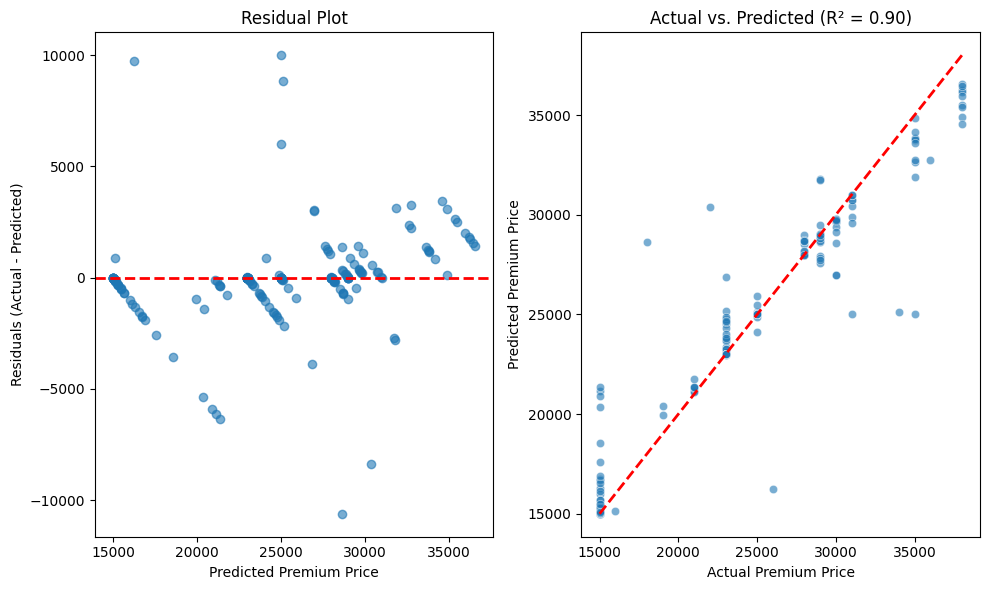

In [43]:
# Hyperparameter Tuning for Random Forest Regressor
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train, y_train)

print("Best Parameters:", grid_search_rf.best_params_)
print()
best_rf = grid_search_rf.best_estimator_

# Fitting the best model
best_rf.fit(X_train, y_train)

y_train_pred_rf = best_rf.predict(X_train)
model_metrics('Random Forest Regressor', 'Train Data', y_train, y_train_pred_rf)
print()
y_test_pred_rf = best_rf.predict(X_test)
model_metrics('Random Forest Regressor', 'Test Data', y_test, y_test_pred_rf)

# Plotting Residuals
plot_residuals(best_rf)

#### **Gradient Boosting Regressor**

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}

Prediction Result of Gradient Boosting Regressor on Train Data
Gradient Boosting Regressor MAE: 857.37
Gradient Boosting Regressor RMSE: 1677.67
Gradient Boosting Regressor R^2: 0.93 

Prediction Result of Gradient Boosting Regressor on Test Data
Gradient Boosting Regressor MAE: 1242.41
Gradient Boosting Regressor RMSE: 2348.88
Gradient Boosting Regressor R^2: 0.87 



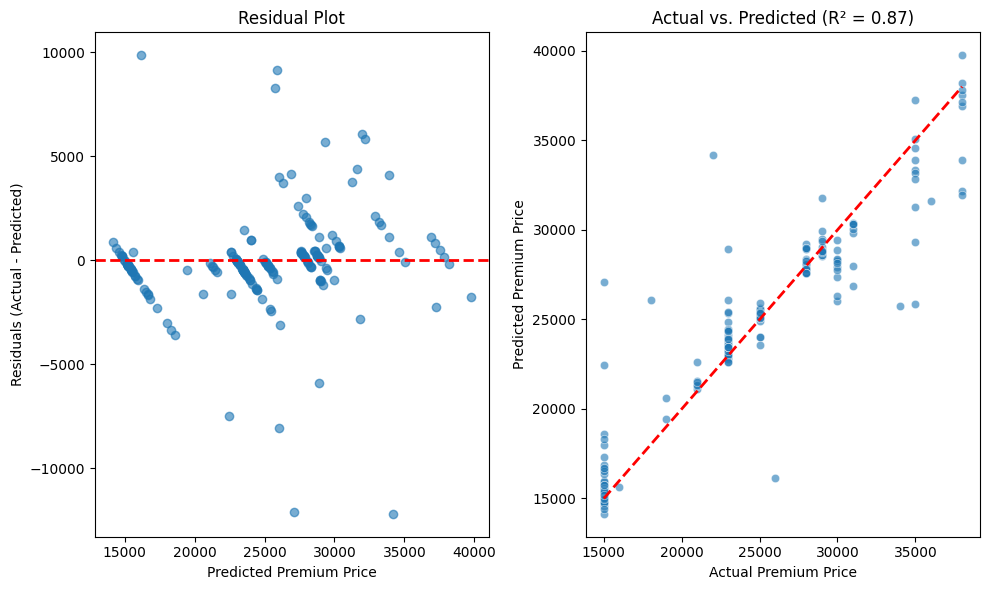

In [44]:
# Hyperparameter Tuning for Gradient Boosting Regressor
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_gbdt = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
grid_search_gbdt.fit(X_train, y_train)

print("Best parameters:", grid_search_gbdt.best_params_)
print()
best_gbdt = grid_search_gbdt.best_estimator_

# Fitting Best Model
best_gbdt.fit(X_train, y_train)

y_train_pred_gbdt = best_gbdt.predict(X_train)
model_metrics('Gradient Boosting Regressor', 'Train Data', y_train, y_train_pred_gbdt)

y_test_pred_gbdt = best_gbdt.predict(X_test)
model_metrics('Gradient Boosting Regressor', 'Test Data', y_test, y_test_pred_gbdt)

# Plotting Residuals
plot_residuals(best_gbdt)

#### **XGB Regressor**

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.6}

Prediction Result of XGB Regressor on Train Data
XGB Regressor MAE: 884.01
XGB Regressor RMSE: 1623.04
XGB Regressor R^2: 0.93 

Prediction Result of XGB Regressor on Test Data
XGB Regressor MAE: 1275.48
XGB Regressor RMSE: 2243.17
XGB Regressor R^2: 0.88 



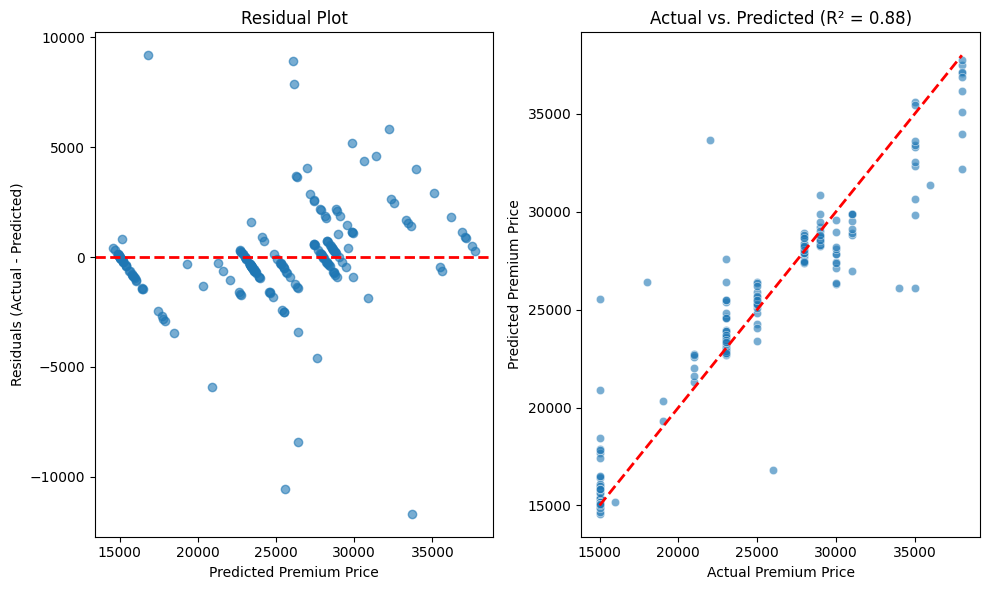

In [45]:
# Hyperparameter Tuning for XGB Regressor
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search_xgb = GridSearchCV(XGBRegressor(objective='reg:squarederror', random_state=42), param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

print("Best parameters:", grid_search_xgb.best_params_)
print()
best_xgb = grid_search_xgb.best_estimator_

# Fitting Best Model
best_xgb.fit(X_train, y_train)

y_train_pred_xgb = best_xgb.predict(X_train)
model_metrics('XGB Regressor', 'Train Data', y_train, y_train_pred_xgb)

y_test_pred_xgb = best_xgb.predict(X_test)
model_metrics('XGB Regressor', 'Test Data', y_test, y_test_pred_xgb)

# Plotting Residuals
plot_residuals(best_xgb)

### Feature Importance

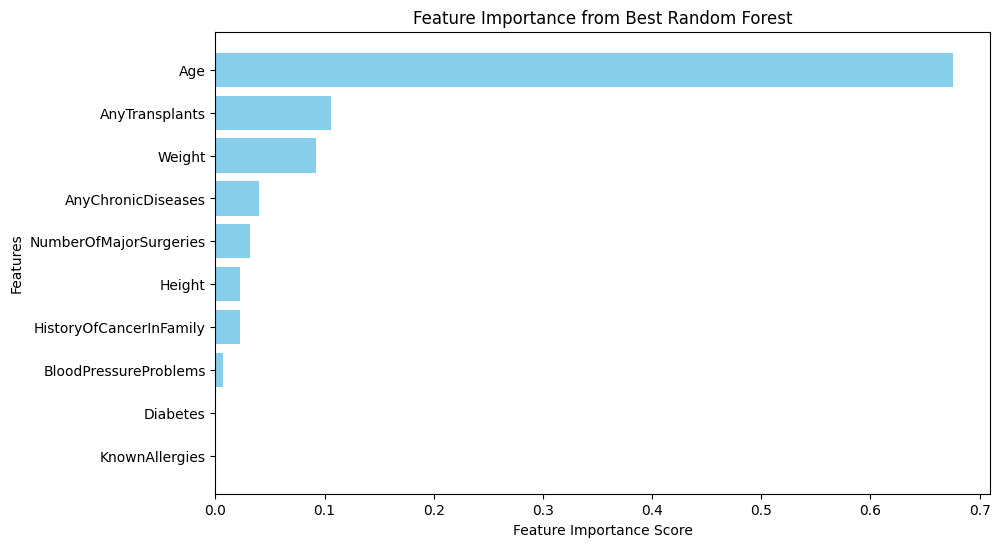

In [46]:
# Get feature importances from the trained Random Forest model
feature_importances = best_rf.feature_importances_

# Get feature names
feature_names = X_train.columns

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = feature_names[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color="skyblue")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance from Best Random Forest")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()


- Age is the most Important feature in predicting Premium price
- Diabetes and Known Allergies has no or less impact on Premium price

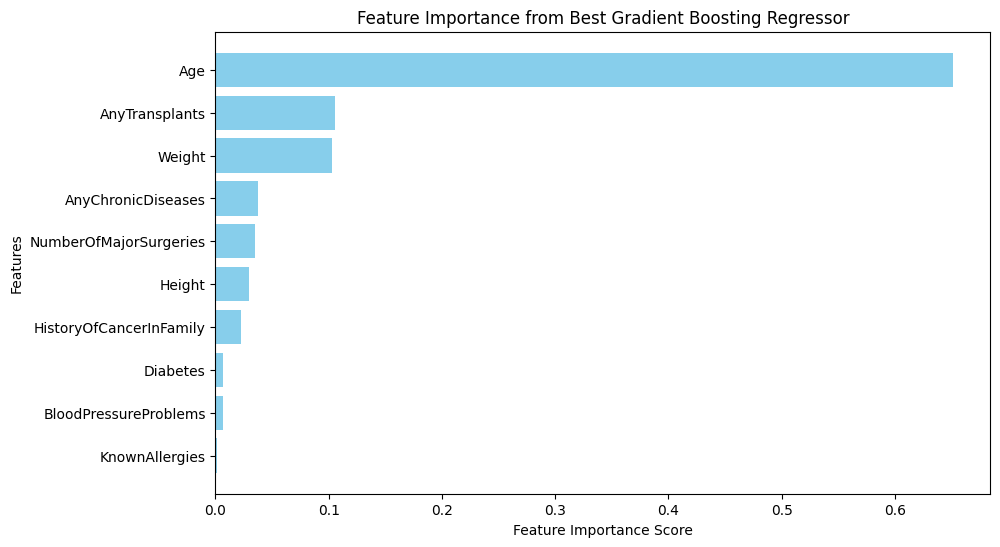

In [47]:
# Get feature importances from the trained Gradient Boosting Regressor model
feature_importances = best_gbdt.feature_importances_

# Get feature names
feature_names = X_train.columns

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = feature_names[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color="skyblue")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance from Best Gradient Boosting Regressor")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

- Age is the most Important feature in predicting Premium price
- Known Allergies has least impact in predicting Premium price

In [48]:
# !pip install shap

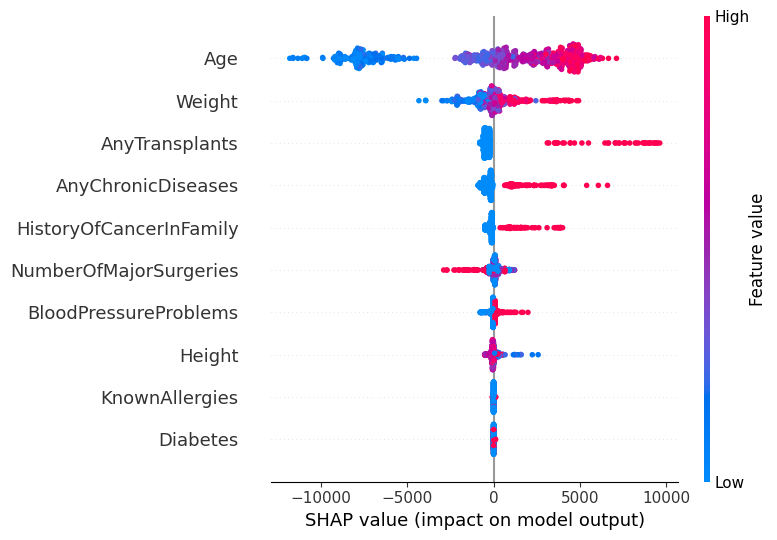

In [49]:
# Best Random Forest model’s predictions using SHAP
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_train)

# Summary plot
shap.summary_plot(shap_values, X_train)


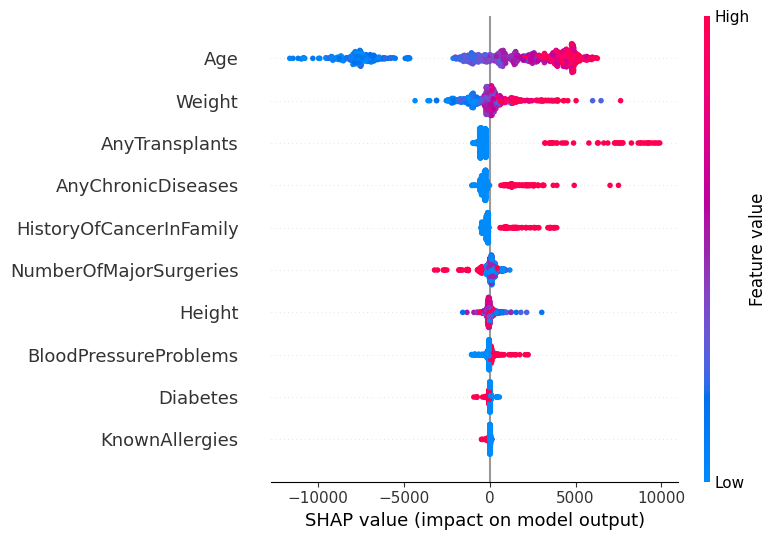

In [50]:
# Best GBDT model’s predictions using SHAP
explainer = shap.TreeExplainer(best_gbdt)
shap_values = explainer.shap_values(X_train)

# Summary plot
shap.summary_plot(shap_values, X_train)

### Selecting Saving trained model to Pickle file

In [51]:
# Dumping Model in pickle file
model_file = open('model.pkl',mode='wb')
pickle.dump(best_rf, model_file)
model_file.close()

#### **Evaluating model performance**
While analyzing metrics for Random Forest, Gradient Boosting, and XGB models. Random Forest shows moderate error with high R2, Gradient Boosting shows potential overfitting, and XGB has low training errors but higher test errors.
#### **Assessing model metrics**
Random Forest exhibits a slight edge on test data, with an R2 of 0.9, compared to other models: Ridge (0.71), Lasso (0.71), ElasticNet(0.71), Gradient Boosting (0.87) and XGB (0.88).
#### **Observations**
##### *Generalization (Train vs. Test Performance):*
While some models (especially the XGB) achieve very high performance on the training set (e.g., lower errors and higher R²), their performance on the test data is not as strong. This gap between train and test results is a sign of overfitting.
#### Random Forest Regressor:
- The Random Forest shows comparable train and test metrics.
- Its test performance (MAE ≈ 994.44, RMSE ≈ 2078.73, R² ≈ 0.90) indicates good generalization.
- The close alignment between train and test metrics suggests that the model is not overfitting.